In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV,StratifiedKFold

In [2]:
path = "./data/"

In [3]:
user_info_path = "user_info_format1.csv"
user_actions_path = "user_log_format1.csv"
train_path = "train_format1.csv"
submit_path = "test_format1.csv"

In [13]:
user_info = pd.read_csv(path + user_info_path)
userXmerchant_with_label = pd.read_csv(path + train_path)
user_actions = pd.read_csv(path + user_actions_path)
userXmerchant_for_submit = pd.read_csv(path + submit_path)

In [28]:
userXmerchant = pd.concat([userXmerchant_with_label,userXmerchant_for_submit])
userXmerchant["label"].fillna(-1,inplace=True)

In [14]:
user_actions.rename(columns={"seller_id":"merchant_id"},inplace=True)

In [29]:
user_actions_with_label = pd.merge(user_actions,userXmerchant,on=["user_id","merchant_id"],how="inner")
#user_actions_for_submit = pd.merge(user_actions,userXmerchant_for_submit,on=["user_id","merchant_id"],how="inner")

In [84]:
userXmerchant[["user_id"]].drop_duplicates(subset=["user_id"])

,user_id
0,34176
4,230784
5,362112
6,34944
7,231552
...,...
261468,292991
261469,293759
261471,228479
261473,97919


# baseline

- 合并特征和标签

In [30]:
featureAndlabel = pd.merge(userXmerchant,user_info,on="user_id",how="left")
# submit_feature = pd.merge(userXmerchant_for_submit,user_info,on="user_id",how="left")

- 切分训练集和验证集

In [31]:
# 切分训练集和验证集
train_y = featureAndlabel.loc[featureAndlabel.label != -1,["label"]]
train_X = train_featureAndlabel.loc[featureAndlabel.label != -1,["age_range","gender"]]
train_X,test_X,train_y,test_y = train_test_split(train_X, train_y, test_size = 0.3, stratify = train_y)
# test_X = test[["age_range","gender"]].values

- 模型训练

In [32]:
gbm = lgb.LGBMClassifier()
gbm.fit(train_X,train_y)

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

- 模型评估：auc

In [33]:
# 训练集效果
roc_auc_score(train_y,gbm.predict_proba(train_X)[:,1])

0.541558419515597

In [34]:
# 验证集效果
roc_auc_score(test_y,gbm.predict_proba(test_X)[:,1])

0.5387576529824986

- 特征重要度

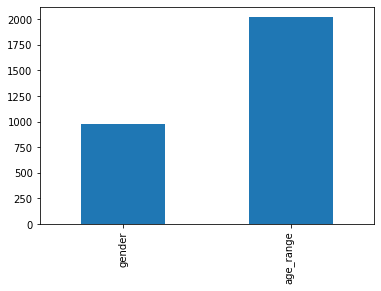

In [35]:
feature_importances = gbm.feature_importances_
feature_importances = pd.Series(feature_importances,index=train_X.columns)
feature_importances.sort_values().plot(kind="bar")

- 产出预测结果

In [36]:
submit_X = featureAndlabel.loc[featureAndlabel.label == -1,["age_range","gender"]].values
res = submit_feature[["user_id","merchant_id"]]
res["prob"] = gbm.predict_proba(submit_X)[:,1]

D:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [37]:
res

,user_id,merchant_id,prob
0,163968,4605,0.062872
1,360576,1581,0.028736
2,98688,1964,0.071955
3,98688,3645,0.071955
4,295296,3361,0.044726
...,...,...,...
261472,228479,3111,0.071955
261473,97919,2341,0.048683
261474,97919,3971,0.048683
261475,32639,3536,0.062872


In [24]:
res.to_csv(path + "prediction.csv")

- 样本均衡

In [48]:
train[["label","gender"]].groupby(["label"]).count()

,gender
label,
0,241315
1,15838


In [82]:
241315/15838

15.236456623311025

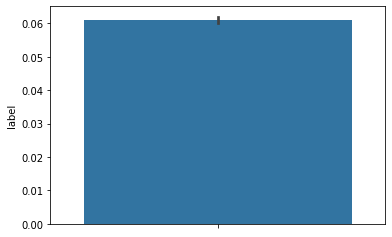

In [52]:
# 样本不均衡
sns.barplot(y = train.label)

In [15]:
user_actions_with_label.isnull().any()

user_id        False
item_id        False
cat_id         False
merchant_id    False
brand_id        True
time_stamp     False
action_type    False
label          False
dtype: bool

In [16]:
user_actions_with_label.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2824241 entries, 0 to 2824240
Data columns (total 8 columns):
 #   Column       Dtype  
---  ------       -----  
 0   user_id      int64  
 1   item_id      int64  
 2   cat_id       int64  
 3   merchant_id  int64  
 4   brand_id     float64
 5   time_stamp   int64  
 6   action_type  int64  
 7   label        int64  
dtypes: float64(1), int64(7)
memory usage: 193.9 MB


# 特征工程

## 用户侧特征

- 用户行为计数特征

In [41]:
# 用户行为计数特征
user_actions_count = user_actions[["user_id","action_type"]].groupby(["user_id"]).count().reset_index()
user_actions_count.rename(columns={"action_type":"user_actions_count"},inplace=True)
featureAndlabel = pd.merge(featureAndlabel,user_actions_count,on="user_id",how="left")
# submit_feature = pd.merge(submit_feature,user_actions_count,on="user_id",how="left")
featureAndlabel["user_actions_count"].fillna(0,inplace=True)
# submit_feature["user_actions_count"].fillna(0,inplace=True)

In [42]:
# 用户各种行为计数
# 0：点击 1：加购物车 2：购买 3：加收藏
for i in [0, 1, 2, 3]:
    temp = user_actions.loc[user_actions.action_type == i,["user_id","action_type"]].groupby(["user_id"]).count().reset_index()
    temp.rename(columns={"action_type":"user_action_type" + str(i) + "_count"},inplace=True)
    featureAndlabel = pd.merge(featureAndlabel,temp,on="user_id",how="left")
    # submit_feature = pd.merge(featureAndlabel,temp,on="user_id",how="left")
    featureAndlabel["user_action_type" + str(i) + "_count"].fillna(0,inplace=True)

In [46]:
# 非购买行为计数
temp = user_actions.loc[user_actions.action_type != 2,["user_id","action_type"]].groupby(["user_id"]).count().reset_index()
temp.rename(columns={"action_type":"user_action_nopurchase_count"},inplace=True)
featureAndlabel = pd.merge(featureAndlabel,temp,on="user_id",how="left")
featureAndlabel["user_action_nopurchase_count"].fillna(0,inplace=True)

- 用户购买行为比例

In [49]:
# 用户购买行为比例
featureAndlabel["user_purchase_rate"] = featureAndlabel["user_action_type2_count"]/featureAndlabel["user_actions_count"]
featureAndlabel["user_purchase_rate"].fillna(0,inplace=True)

- 用户有行为的店铺计数

In [51]:
user_merchant_count = user_actions[["user_id","merchant_id"]].drop_duplicates(subset=["user_id","merchant_id"]).groupby(["user_id"]).count().reset_index()
user_merchant_count.rename(columns={"merchant_id":"user_merchant_count"},inplace=True)
featureAndlabel = pd.merge(featureAndlabel,user_merchant_count,on="user_id",how="left")
featureAndlabel["user_merchant_count"].fillna(0,inplace=True)

## 用户x商家特征

- 用户x店铺的行为计数特征

In [52]:
user_actions_with_label.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5662515 entries, 0 to 5662514
Data columns (total 9 columns):
 #   Column       Dtype  
---  ------       -----  
 0   user_id      int64  
 1   item_id      int64  
 2   cat_id       int64  
 3   merchant_id  int64  
 4   brand_id     float64
 5   time_stamp   int64  
 6   action_type  int64  
 7   label        float64
 8   prob         float64
dtypes: float64(3), int64(6)
memory usage: 432.0 MB


In [53]:
# 用户x店铺行为计数特征
userXmerchant_actions_count = user_actions_with_label[["user_id","merchant_id","action_type"]].groupby(["user_id","merchant_id"]).count().reset_index()
userXmerchant_actions_count.rename(columns={"action_type":"userXmerchant_actions_count"},inplace=True)
featureAndlabel = pd.merge(featureAndlabel,userXmerchant_actions_count,on=["user_id","merchant_id"],how="left")
featureAndlabel["userXmerchant_actions_count"].fillna(0,inplace=True)

In [54]:
# 用户x店铺各种行为计数
for i in [0, 1, 2, 3]:
    temp = user_actions_with_label.loc[user_actions_with_label.action_type == i,["user_id","merchant_id","action_type"]].groupby(["user_id","merchant_id"]).count().reset_index()
    temp.rename(columns={"action_type":"userXmerchant_action_type" + str(i) + "_count"},inplace=True)
    featureAndlabel = pd.merge(featureAndlabel,temp,on=["user_id","merchant_id"],how="left")
    featureAndlabel["userXmerchant_action_type" + str(i) + "_count"].fillna(0,inplace=True)

- 用户x店铺购买行为比例

In [55]:
featureAndlabel["userXmerchant_purchase_rate"] = featureAndlabel["userXmerchant_action_type2_count"]/featureAndlabel["userXmerchant_actions_count"]
featureAndlabel["userXmerchant_purchase_rate"].fillna(0,inplace=True)

- 用户对当前店铺的行为占其行为总数的比例

In [56]:
featureAndlabel["userXmerchant_actions_fraction"] = featureAndlabel["userXmerchant_actions_count"]/featureAndlabel["user_actions_count"]
featureAndlabel["userXmerchant_actions_fraction"].fillna(0,inplace=True)

## 店铺侧特征

- 店铺热度

In [57]:
# 店铺顾客行为总数
merchant_act_count = user_actions[["merchant_id","action_type"]].groupby(["merchant_id"]).count().reset_index()
merchant_act_count.rename(columns={"action_type":"merchant_act_count"},inplace=True)
featureAndlabel = pd.merge(featureAndlabel,merchant_act_count,on="merchant_id",how="left")
featureAndlabel["merchant_act_count"].fillna(0,inplace=True)

In [58]:
# 店铺购买行为总数
merchant_purchase_rate = user_actions.loc[user_actions.action_type == 2,["merchant_id","action_type"]].groupby(["merchant_id"]).count().reset_index()
merchant_purchase_rate.rename(columns={"action_type":"merchant_purchase_rate"},inplace=True)
featureAndlabel = pd.merge(featureAndlabel,merchant_purchase_rate,on="merchant_id",how="left")
featureAndlabel["merchant_purchase_rate"].fillna(0,inplace=True)

In [59]:
# 店铺客流量
merchant_user_count = user_actions[["merchant_id","user_id"]].drop_duplicates(["merchant_id","user_id"]).groupby(["merchant_id"]).count().reset_index()
merchant_user_count.rename(columns={"user_id":"merchant_user_count"},inplace=True)
featureAndlabel = pd.merge(featureAndlabel,merchant_user_count,on="merchant_id",how="left")
featureAndlabel["merchant_user_count"].fillna(0,inplace=True)

In [60]:
# 店铺客户转化数
merchant_purchase_user_count = user_actions.loc[user_actions.action_type == 2,["merchant_id","user_id"]].drop_duplicates(["merchant_id","user_id"]).groupby(["merchant_id"]).count().reset_index()
merchant_purchase_user_count.rename(columns={"user_id":"merchant_purchase_user_count"},inplace=True)
featureAndlabel = pd.merge(featureAndlabel,merchant_purchase_user_count,on="merchant_id",how="left")
featureAndlabel["merchant_purchase_user_count"].fillna(0,inplace=True)

In [62]:
featureAndlabel.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 522341 entries, 0 to 522340
Data columns (total 25 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   user_id                           522341 non-null  int64  
 1   merchant_id                       522341 non-null  int64  
 2   label                             522341 non-null  float64
 3   prob                              0 non-null       float64
 4   age_range                         519763 non-null  float64
 5   gender                            514796 non-null  float64
 6   user_actions_count                522341 non-null  int64  
 7   user_action_type0_count           522341 non-null  float64
 8   user_action_type1_count           522341 non-null  float64
 9   user_action_type2_count           522341 non-null  int64  
 10  user_action_type3_count           522341 non-null  float64
 11  user_action_nopurchase_count      522341 non-null  f

## 增强版本：行为特征工程

In [63]:
y = featureAndlabel.loc[featureAndlabel.label != -1,["label"]]
X = featureAndlabel.loc[featureAndlabel.label != -1,:].drop(columns=["user_id","merchant_id","label"])

In [64]:
# 分层抽样
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.3, stratify=y)

- 模型训练

- lightGBM gbdt提升树分类

In [65]:
gbm = lgb.LGBMClassifier()
gbm.fit(X_train,y_train)

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

- 模型评估：由于样本不均衡，使用auc进行评估

In [66]:
# 验证集auc
y_test_prob = gbm.predict_proba(X_test)[:,1]
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test,y_test_prob)

0.6552950166178788

In [67]:
# 训练集auc
y_test_prob = gbm.predict_proba(X_train)[:,1]
roc_auc_score(y_train,y_test_prob)

0.7395059857772662

- 可能有过拟合现象，调参

#### 学习率和迭代次数

In [43]:
params = {
    "boosting_type":"gbdt",
    "objective":"binary",
    "metric":"auc",
    "ntheard": 8,
    "learning_rate":0.1,
    "num_leaves":30,
    "max_depth":5,
    "subsample":0.8,
    "colsample_bytree":0.8    
}
data_train = lgb.Dataset(X_train.values,y_train.values)
cv_result = lgb.cv(params, data_train, num_boost_round=1000, nfold=5, stratified=True, metrics="auc", early_stopping_rounds=100, seed=0, shuffle=True)

In [46]:
print("最优迭代轮次：" + str(len(cv_result["auc-mean"])))
print("最优auc-score:" + str(max(cv_result["auc-mean"])))

最优迭代轮次：161
最优auc-score:0.6571137569389685


#### max_depth和num_leaves

In [51]:
params_maxdepthAnumleaves = {
    "max_depth":range(3,8,1),
    "num_leaves":range(5,100,5)
}
skf = StratifiedKFold(n_splits=5,shuffle=True)
gsearch1 = GridSearchCV(estimator=lgb.LGBMClassifier(boosting_type="gbdt",objective="binary",metrics="auc",learning_rate=0.1, n_estimators=188, bagging_fraction=0.8, feature_fraction = 0.8),
                       param_grid=params_maxdepthAnumleaves, scoring="roc_auc", cv=skf, n_jobs=-1)
gsearch1.fit(X_train,y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
             error_score=nan,
             estimator=LGBMClassifier(bagging_fraction=0.8,
                                      boosting_type='gbdt', class_weight=None,
                                      colsample_bytree=1.0,
                                      feature_fraction=0.8,
                                      importance_type='split',
                                      learning_rate=0.1, max_depth=-1,
                                      metrics='auc', min_child_samples=20,
                                      min_child_weight=0.001,
                                      min_split_gain=0.0,...imators=188,
                                      n_jobs=-1, num_leaves=31,
                                      objective='binary', random_state=None,
                                      reg_alpha=0.0, reg_lambda=0.0,
                                      silent=True, subsample=1.0,
             

In [52]:
gsearch1.best_params_, gsearch1.best_score_

({'max_depth': 5, 'num_leaves': 15}, 0.6587682574967324)

#### min_data_in_leaf和max_bin

In [57]:
params_mindatainleafAmaxbin = {
    "min_data_in_leaf":range(201,301,10),
    "max_bin":range(5,256,10)
}
gsearch2 = GridSearchCV(estimator=lgb.LGBMClassifier(boosting_type="gbdt",
                                                    objective="binary",
                                                    max_depth=5,
                                                    num_leaves=15,
                                                    metrics="auc",
                                                    learning_rate=0.1,
                                                    n_estimators=161,
                                                    bagging_fraction=0.8,
                                                    feature_fraction=0.8),
                        param_grid=params_mindatainleafAmaxbin,
                        cv=skf,
                        n_jobs=-1,
                        scoring="roc_auc")
gsearch2.fit(X_train,y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
             error_score=nan,
             estimator=LGBMClassifier(bagging_fraction=0.8,
                                      boosting_type='gbdt', class_weight=None,
                                      colsample_bytree=1.0,
                                      feature_fraction=0.8,
                                      importance_type='split',
                                      learning_rate=0.1, max_depth=5,
                                      metrics='auc', min_child_samples=20,
                                      min_child_weight=0.001,
                                      min_split_gain=0.0, n...
                                      n_jobs=-1, num_leaves=15,
                                      objective='binary', random_state=None,
                                      reg_alpha=0.0, reg_lambda=0.0,
                                      silent=True, subsample=1.0,
                        

In [58]:
gsearch2.best_params_, gsearch2.best_score_, gsearch2.best_estimator_

({'max_bin': 245, 'min_data_in_leaf': 261},
 0.6595017328896366,
 LGBMClassifier(bagging_fraction=0.8, boosting_type='gbdt', class_weight=None,
                colsample_bytree=1.0, feature_fraction=0.8,
                importance_type='split', learning_rate=0.1, max_bin=245,
                max_depth=5, metrics='auc', min_child_samples=20,
                min_child_weight=0.001, min_data_in_leaf=261, min_split_gain=0.0,
                n_estimators=161, n_jobs=-1, num_leaves=15, objective='binary',
                random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
                subsample=1.0, subsample_for_bin=200000, subsample_freq=0))

#### feature_fraction(特征抽样比例),bagging_fraction(样本抽样比例),bagging_freq

In [59]:
params_test3 = {
    "feature_fraction":[0.6,0.7,0.8,0.9,1.0],
    "bagging_fraction":[0.6,0.7,0.8,0.9,1.0],
    "bagging_freq":range(0,81,10)
}

gsearch3 = GridSearchCV(estimator=lgb.LGBMClassifier(bagging_fraction=0.8, boosting_type='gbdt', class_weight=None,
                colsample_bytree=1.0, feature_fraction=0.8,
                importance_type='split', learning_rate=0.1, max_bin=245,
                max_depth=5, metrics='auc', min_child_samples=20,
                min_child_weight=0.001, min_data_in_leaf=261, min_split_gain=0.0,
                n_estimators=161, n_jobs=-1, num_leaves=15, objective='binary',
                random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
                subsample=1.0, subsample_for_bin=200000, subsample_freq=0),
                       param_grid=params_test3,
                       cv=skf,
                       scoring="roc_auc")
gsearch3.fit(X_train,y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
             error_score=nan,
             estimator=LGBMClassifier(bagging_fraction=0.8,
                                      boosting_type='gbdt', class_weight=None,
                                      colsample_bytree=1.0,
                                      feature_fraction=0.8,
                                      importance_type='split',
                                      learning_rate=0.1, max_bin=245,
                                      max_depth=5, metrics='auc',
                                      min_child_samples=20,
                                      min_child_weight=0.001,
                                      min_data...
                                      random_state=None, reg_alpha=0.0,
                                      reg_lambda=0.0, silent=True,
                                      subsample=1.0, subsample_for_bin=200000,
                                      subsam

In [60]:
gsearch3.best_params_, gsearch3.best_score_, gsearch3.best_estimator_

({'bagging_fraction': 0.6, 'bagging_freq': 0, 'feature_fraction': 0.7},
 0.658539233770839,
 LGBMClassifier(bagging_fraction=0.6, bagging_freq=0, boosting_type='gbdt',
                class_weight=None, colsample_bytree=1.0, feature_fraction=0.7,
                importance_type='split', learning_rate=0.1, max_bin=245,
                max_depth=5, metrics='auc', min_child_samples=20,
                min_child_weight=0.001, min_data_in_leaf=261, min_split_gain=0.0,
                n_estimators=161, n_jobs=-1, num_leaves=15, objective='binary',
                random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
                subsample=1.0, subsample_for_bin=200000, subsample_freq=0))

#### lambda_l1和lambda_l2

In [61]:
params_test4={
    "lambda_l1":[1e-5,1e-3,1e-1,0.0,0.1,0.3,0.5,0.7,0.9,1.0],
    "lambda_l2":[1e-5,1e-3,1e-1,0.0,0.1,0.3,0.5,0.7,0.9,1.0]
}

gsearch4 = GridSearchCV(estimator=lgb. LGBMClassifier(bagging_fraction=0.6, bagging_freq=0, boosting_type='gbdt',
                class_weight=None, colsample_bytree=1.0, feature_fraction=0.7,
                importance_type='split', learning_rate=0.1, max_bin=245,
                max_depth=5, metrics='auc', min_child_samples=20,
                min_child_weight=0.001, min_data_in_leaf=261, min_split_gain=0.0,
                n_estimators=161, n_jobs=-1, num_leaves=15, objective='binary',
                random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
                subsample=1.0, subsample_for_bin=200000, subsample_freq=0),
                       param_grid=params_test4,
                       scoring="roc_auc",
                       cv=skf,
                       n_jobs=-1)

gsearch4.fit(X_train,y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
             error_score=nan,
             estimator=LGBMClassifier(bagging_fraction=0.6, bagging_freq=0,
                                      boosting_type='gbdt', class_weight=None,
                                      colsample_bytree=1.0,
                                      feature_fraction=0.7,
                                      importance_type='split',
                                      learning_rate=0.1, max_bin=245,
                                      max_depth=5, metrics='auc',
                                      min_child_samples=20,
                                      min_child_weight...
                                      random_state=None, reg_alpha=0.0,
                                      reg_lambda=0.0, silent=True,
                                      subsample=1.0, subsample_for_bin=200000,
                                      subsample_freq=0),
             iid='depreca

In [62]:
gsearch4.best_params_, gsearch4.best_score_, gsearch4.best_estimator_

({'lambda_l1': 0.9, 'lambda_l2': 0.5},
 0.6607016395347521,
 LGBMClassifier(bagging_fraction=0.6, bagging_freq=0, boosting_type='gbdt',
                class_weight=None, colsample_bytree=1.0, feature_fraction=0.7,
                importance_type='split', lambda_l1=0.9, lambda_l2=0.5,
                learning_rate=0.1, max_bin=245, max_depth=5, metrics='auc',
                min_child_samples=20, min_child_weight=0.001,
                min_data_in_leaf=261, min_split_gain=0.0, n_estimators=161,
                n_jobs=-1, num_leaves=15, objective='binary', random_state=None,
                reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
                subsample_for_bin=200000, subsample_freq=0))

#### min_split_gain

In [65]:
params_test5 = {
    "min_split_gain":[0.0,.1,.2,.3,.4,.5,.6,.7,.8,.9,1.0]
}

gsearch5 = GridSearchCV(estimator=lgb.LGBMClassifier(bagging_fraction=0.6, bagging_freq=0, boosting_type='gbdt',
                class_weight=None, colsample_bytree=1.0, feature_fraction=0.7,
                importance_type='split', lambda_l1=0.9, lambda_l2=0.5,
                learning_rate=0.1, max_bin=245, max_depth=5, metrics='auc',
                min_child_samples=20, min_child_weight=0.001,
                min_data_in_leaf=261, min_split_gain=0.0, n_estimators=161,
                n_jobs=-1, num_leaves=15, objective='binary', random_state=None,
                reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
                subsample_for_bin=200000, subsample_freq=0),
                       param_grid=params_test5,
                       scoring="roc_auc",
                       cv=skf,
                       n_jobs=-1)
gsearch5.fit(X_train,y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
             error_score=nan,
             estimator=LGBMClassifier(bagging_fraction=0.6, bagging_freq=0,
                                      boosting_type='gbdt', class_weight=None,
                                      colsample_bytree=1.0,
                                      feature_fraction=0.7,
                                      importance_type='split', lambda_l1=0.9,
                                      lambda_l2=0.5, learning_rate=0.1,
                                      max_bin=245, max_depth=5, metrics='auc',
                                      min_child...
                                      n_estimators=161, n_jobs=-1,
                                      num_leaves=15, objective='binary',
                                      random_state=None, reg_alpha=0.0,
                                      reg_lambda=0.0, silent=True,
                                      subsample=1.0, subsa

In [66]:
gsearch5.best_params_, gsearch5.best_score_, gsearch5.best_estimator_

({'min_split_gain': 0.4},
 0.6591248418939999,
 LGBMClassifier(bagging_fraction=0.6, bagging_freq=0, boosting_type='gbdt',
                class_weight=None, colsample_bytree=1.0, feature_fraction=0.7,
                importance_type='split', lambda_l1=0.9, lambda_l2=0.5,
                learning_rate=0.1, max_bin=245, max_depth=5, metrics='auc',
                min_child_samples=20, min_child_weight=0.001,
                min_data_in_leaf=261, min_split_gain=0.4, n_estimators=161,
                n_jobs=-1, num_leaves=15, objective='binary', random_state=None,
                reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
                subsample_for_bin=200000, subsample_freq=0))

#### 降低学习率，增加迭代次数，验证模型

In [67]:
model = lgb.LGBMClassifier(bagging_fraction=0.6, bagging_freq=0, boosting_type='gbdt',
                class_weight=None, colsample_bytree=1.0, feature_fraction=0.7,
                importance_type='split', lambda_l1=0.9, lambda_l2=0.5,
                learning_rate=0.01, max_bin=245, max_depth=5, metrics='auc',
                min_child_samples=20, min_child_weight=0.001,
                min_data_in_leaf=261, min_split_gain=0.4, n_estimators=2000,
                n_jobs=-1, num_leaves=15, objective='binary', random_state=None,
                reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
                subsample_for_bin=200000, subsample_freq=0)
model.fit(X_train,y_train)

LGBMClassifier(bagging_fraction=0.6, bagging_freq=0, boosting_type='gbdt',
               class_weight=None, colsample_bytree=1.0, feature_fraction=0.7,
               importance_type='split', lambda_l1=0.9, lambda_l2=0.5,
               learning_rate=0.01, max_bin=245, max_depth=5, metrics='auc',
               min_child_samples=20, min_child_weight=0.001,
               min_data_in_leaf=261, min_split_gain=0.4, n_estimators=2000,
               n_jobs=-1, num_leaves=15, objective='binary', random_state=None,
               reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)

#### 计算auc

In [68]:
y_test_pro_pred = model.predict_proba(X_test)[:,1]
roc_auc_score(y_test, y_test_pro_pred)

0.6705468590900265

- 特征重要度

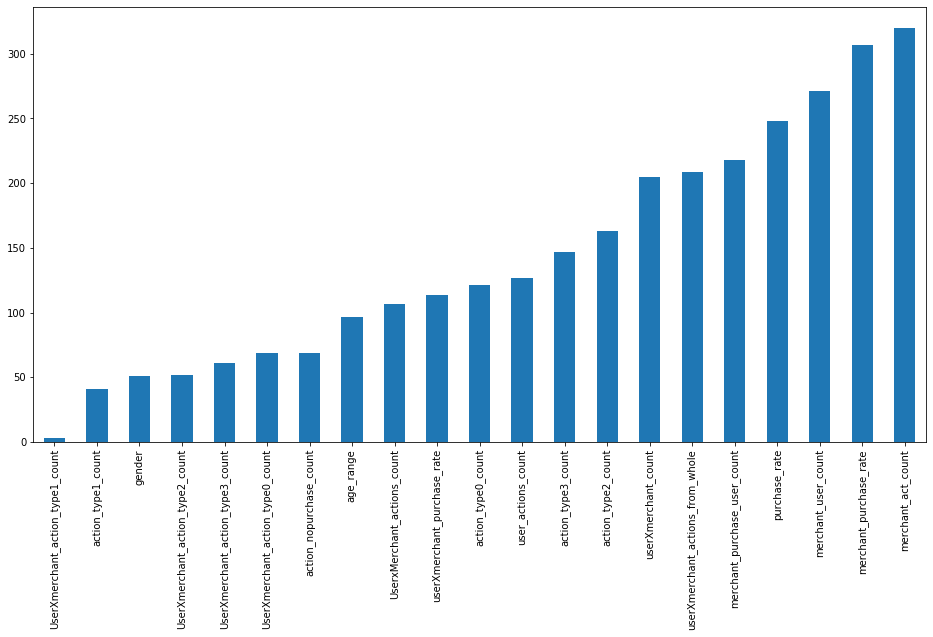

In [71]:
feature_importances = gbm.feature_importances_
feature_importances = pd.Series(feature_importances,index=X_train.columns)
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 16, 8
feature_importances.sort_values().plot(kind="bar")

#### 使用最优的模型&全量数据训练产出结果

In [68]:
model = lgb.LGBMClassifier(bagging_fraction=0.6, bagging_freq=0, boosting_type='gbdt',
                class_weight=None, colsample_bytree=1.0, feature_fraction=0.7,
                importance_type='split', lambda_l1=0.9, lambda_l2=0.5,
                learning_rate=0.01, max_bin=245, max_depth=5, metrics='auc',
                min_child_samples=20, min_child_weight=0.001,
                min_data_in_leaf=261, min_split_gain=0.4, n_estimators=2000,
                n_jobs=-1, num_leaves=15, objective='binary', random_state=None,
                reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
                subsample_for_bin=200000, subsample_freq=0)
model.fit(X,y)

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LGBMClassifier(bagging_fraction=0.6, bagging_freq=0, boosting_type='gbdt',
               class_weight=None, colsample_bytree=1.0, feature_fraction=0.7,
               importance_type='split', lambda_l1=0.9, lambda_l2=0.5,
               learning_rate=0.01, max_bin=245, max_depth=5, metrics='auc',
               min_child_samples=20, min_child_weight=0.001,
               min_data_in_leaf=261, min_split_gain=0.4, n_estimators=2000,
               n_jobs=-1, num_leaves=15, objective='binary', random_state=None,
               reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)

In [70]:
submit_X = featureAndlabel.loc[featureAndlabel.label == -1,:].drop(columns=["user_id","merchant_id","label"]).values
res = featureAndlabel.loc[featureAndlabel.label == -1,["user_id","merchant_id"]]
res["prob"] = model.predict_proba(submit_X)[:,1]
res

,user_id,merchant_id,prob
260864,163968,4605,0.055125
260865,360576,1581,0.077502
260866,98688,1964,0.058962
260867,98688,3645,0.047409
260868,295296,3361,0.078730
...,...,...,...
522336,228479,3111,0.047623
522337,97919,2341,0.039239
522338,97919,3971,0.112432
522339,32639,3536,0.043264


In [79]:
res.to_csv("./res/prediction.csv",index=False,header=True)